In [8]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#import japanize_matplotlib
from IPython.display import display

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [9]:
# torch

import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot
import torchvision.datasets as datasets
# from torch.utils.data import DataLoader

import os
import torchvision
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
import torchvision.transforms as T # Compose, ToTensor, RandomCrop, RandomHorizontalFlip, RandomRotation, RandomApply
from torch.utils.data import random_split
import torch.utils.data as data
from torch.utils.data.dataloader import DataLoader

import matplotlib.pyplot as plt
from PIL import Image


import torch.nn as nn
import torch.nn.functional as F

In [10]:
# warning off
import warnings
warnings.simplefilter('ignore')

# default font
plt.rcParams['font.size'] = 14

# default graph size
plt.rcParams['figure.figsize'] = (4,4)

# default graph grid
# plt.rcParams['axes.grid'] = True

# numpy precision
np.set_printoptions(suppress=True, precision=5)

# GPU

In [11]:
# device

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Data Preparation

In [15]:
data_dir_path = '/home/yohei/project/cs760/tiny-imagenet-200'
# data_dir_path = './tiny-imagenet-200'

def data_transform():
    return T.Compose([
        T.Resize(64),
        T.ColorJitter(brightness=0.5),
        T.RandomAffine(degrees=15, translate=(0.08,0.08), scale=(0.8,1.2), shear=10),
        T.RandomHorizontalFlip(),
        #T.RandomResizedCrop(64,scale=(0.7, 1.4)),
        T.ToTensor(),
    ])

# data formatting (only one time run at the beginning)
def format_val():
    val_dir = data_dir_path + '/val'
    print("Formatting: {}".format(val_dir))
    val_annotations = "{}/val_annotations.txt".format(val_dir)
    val_dict = {}
    with open(val_annotations, 'r') as f:
        for line in f:
            line = line.strip().split()
            assert(len(line) == 6)
            wnind = line[1]
            img_name = line[0]
            boxes = '\t'.join(line[2:])
            if wnind not in val_dict:
                val_dict[wnind] = []
            entries = val_dict[wnind]
            entries.append((img_name, boxes))
    assert(len(val_dict) == 200)
    for wnind, entries in val_dict.items():
        val_wnind_dir = "{}/{}".format(val_dir, wnind)
        val_images_dir = "{}/images".format(val_dir)
        val_wnind_images_dir = "{}/images".format(val_wnind_dir)
        os.mkdir(val_wnind_dir)
        os.mkdir(val_wnind_images_dir)
        wnind_boxes = "{}/{}_boxes.txt".format(val_wnind_dir, wnind)
        f = open(wnind_boxes, "w")
        for img_name, box in entries:
            source = "{}/{}".format(val_images_dir, img_name)
            dst = "{}/{}".format(val_wnind_images_dir, img_name)
            os.system("cp {} {}".format(source, dst))
            f.write(img_name+'\\'+box+'\\'+'n')
        f.close()
    # os.system("rm -rf %s" % val_images_dir)
    #print("Cleaning up: %s" % val_images_dir)
    print("Formatting val done")
    
    
# create dataset object
train_dataset = ImageFolder(data_dir_path + '/train', transform=data_transform())
test_dataset = ImageFolder(data_dir_path + '/test', transform=T.ToTensor())

# Texting label (only one time run at the beginning)
d = {}

f = open(data_dir_path+'/words.txt','r') 
while(1):
    try:
        key, val = f.readline().split("\t")
        d[key] = val[:-1]
    except Exception:
        break

print(len(d))

aa = train_dataset.classes
for i in range(len(aa)):
    train_dataset.classes[i] = d[aa[i]]

82115


In [16]:
random_seed = 4
torch.manual_seed(random_seed);

val_size = 10000
train_size = len(train_dataset) - val_size

train_ds, val_ds = random_split(train_dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(90000, 10000)

Label:  jinrikisha, ricksha, rickshaw (111)


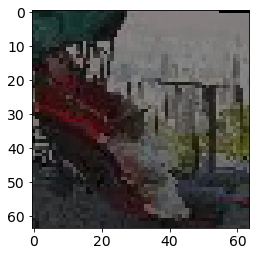

In [17]:
def show_example(img, label):
    print('Label: ', train_dataset.classes[label], "("+str(label)+")")
    img = img.permute(1, 2, 0)
    #print(img.size())
    #print(img.min(),img.max())
    plt.imshow(img)
    
show_example(*train_dataset[55555])

# def of common functions

## eval_loss loss calc

In [18]:
# 損失計算用
def eval_loss(loader, device, net, criterion):
  
    # データローダーから最初の1セットを取得する
    for images, labels in loader:
        break

    # デバイスの割り当て
    inputs = images.to(device)
    labels = labels.to(device)

    # 予測計算
    outputs = net(inputs)

    #  損失計算
    loss = criterion(outputs, labels)

    return loss

## fit learning

In [19]:
def fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history):

    # tqdmライブラリのインポート
    from tqdm.notebook import tqdm

    base_epochs = len(history)
  
    for epoch in range(base_epochs, num_epochs+base_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        #訓練フェーズ
        net.train()
        count = 0

        for inputs, labels in tqdm(train_loader):
            count += len(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 勾配の初期化
            optimizer.zero_grad()

            # 予測計算
            outputs = net(inputs)

            # 損失計算
            loss = criterion(outputs, labels)
            train_loss += loss.item()

            # 勾配計算
            loss.backward()

            # パラメータ修正
            optimizer.step()

            # 予測値算出
            predicted = torch.max(outputs, 1)[1]

            # 正解件数算出
            train_acc += (predicted == labels).sum().item()

            # 損失と精度の計算
            avg_train_loss = train_loss / count
            avg_train_acc = train_acc / count

        #予測フェーズ
        net.eval()
        count = 0

        for inputs, labels in test_loader:
            count += len(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 予測計算
            outputs = net(inputs)

            # 損失計算
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # 予測値算出
            predicted = torch.max(outputs, 1)[1]

            # 正解件数算出
            val_acc += (predicted == labels).sum().item()

            # 損失と精度の計算
            avg_val_loss = val_loss / count
            avg_val_acc = val_acc / count
    
        print (f'Epoch [{(epoch+1)}/{num_epochs+base_epochs}], loss: {avg_train_loss:.5f} acc: {avg_train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {avg_val_acc:.5f}')
        item = np.array([epoch+1, avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc])
        history = np.vstack((history, item))
    return history

## eval_history log analysis of learning

In [20]:
# 学習ログ解析

def evaluate_history(history):
    #損失と精度の確認
    print(f'Initial: loss: {history[0,3]:.5f} accuracy: {history[0,4]:.5f}') 
    print(f'Final: loss: {history[-1,3]:.5f} accuracy: {history[-1,4]:.5f}' )

    num_epochs = len(history)
    unit = num_epochs / 10

    # 学習曲線の表示 (損失)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,1], 'b', label='Training')
    plt.plot(history[:,0], history[:,3], 'k', label='Test(Val)')
    plt.xticks(np.arange(0,num_epochs+1, unit))
    plt.xlabel('# of recursion')
    plt.ylabel('Loss')
    plt.title('Learning Curve (Loss)')
    plt.legend()
    plt.show()

    # 学習曲線の表示 (精度)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,2], 'b', label='Training')
    plt.plot(history[:,0], history[:,4], 'k', label='Test(Val)')
    plt.xticks(np.arange(0,num_epochs+1,unit))
    plt.xlabel('# of recursion')
    plt.ylabel('Accuracy')
    plt.title('Learning Curve (Accuracy)')
    plt.legend()
    plt.show()

##  show_images_labels show image and label

In [21]:
# イメージとラベル表示
def show_images_labels(loader, classes, net, device):

    # データローダーから最初の1セットを取得する
    for images, labels in loader:
        break
    # 表示数は50個とバッチサイズのうち小さい方
    n_size = min(len(images), 20)

    if net is not None:
      # デバイスの割り当て
        inputs = images.to(device)
        labels = labels.to(device)

      # 予測計算
        outputs = net(inputs)
        predicted = torch.max(outputs,1)[1]
      #images = images.to('cpu')

    # 最初のn_size個の表示
    plt.figure(figsize=(20, 15))
    for i in range(n_size):
        ax = plt.subplot(4, 5, i + 1)
        label_name = classes[labels[i]]
        # netがNoneでない場合は、予測結果もタイトルに表示する
        if net is not None:
            predicted_name = classes[predicted[i]]
          # 正解かどうかで色分けをする
            if label_name == predicted_name:
                c = 'green'
            else:
                c = 'blue'
            ax.set_title(label_name + ':' + predicted_name, c=c, fontsize=20)
        # netがNoneの場合は、正解ラベルのみ表示
        else:
            ax.set_title(label_name, fontsize=20)
        # TensorをNumPyに変換
        image_np = images[i].numpy().copy()
        # 軸の順番変更 (channel, row, column) -> (row, column, channel)
        img = np.transpose(image_np, (1, 2, 0))
        # 値の範囲を[-1, 1] -> [0, 1]に戻す
        img = (img + 1)/2
        # 結果表示
        plt.imshow(img)
        ax.set_axis_off()
    plt.show()

In [22]:
# PyTorch乱数固定用

def torch_seed(seed=123):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True

## data prep

In [23]:
image1, label1 = train_dataset[0]
image2, label2 = train_dataset[1330]

print(image1.shape)
print(image2.shape)
print(label1)
print(label2)

torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
0
2


In [24]:
# DataLoader

# size of batch
batch_size = 100

# DataLoarder of Training data
train_loader2 = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

# DataLoarder of Test data
test_loader2 = DataLoader(val_ds,  batch_size=batch_size, shuffle=False) 

In [25]:
# train_loader2から1セット取得
for images2, labels2 in train_loader2:
    break

# それぞれのshape確認
print(images2.shape)



torch.Size([100, 3, 64, 64])


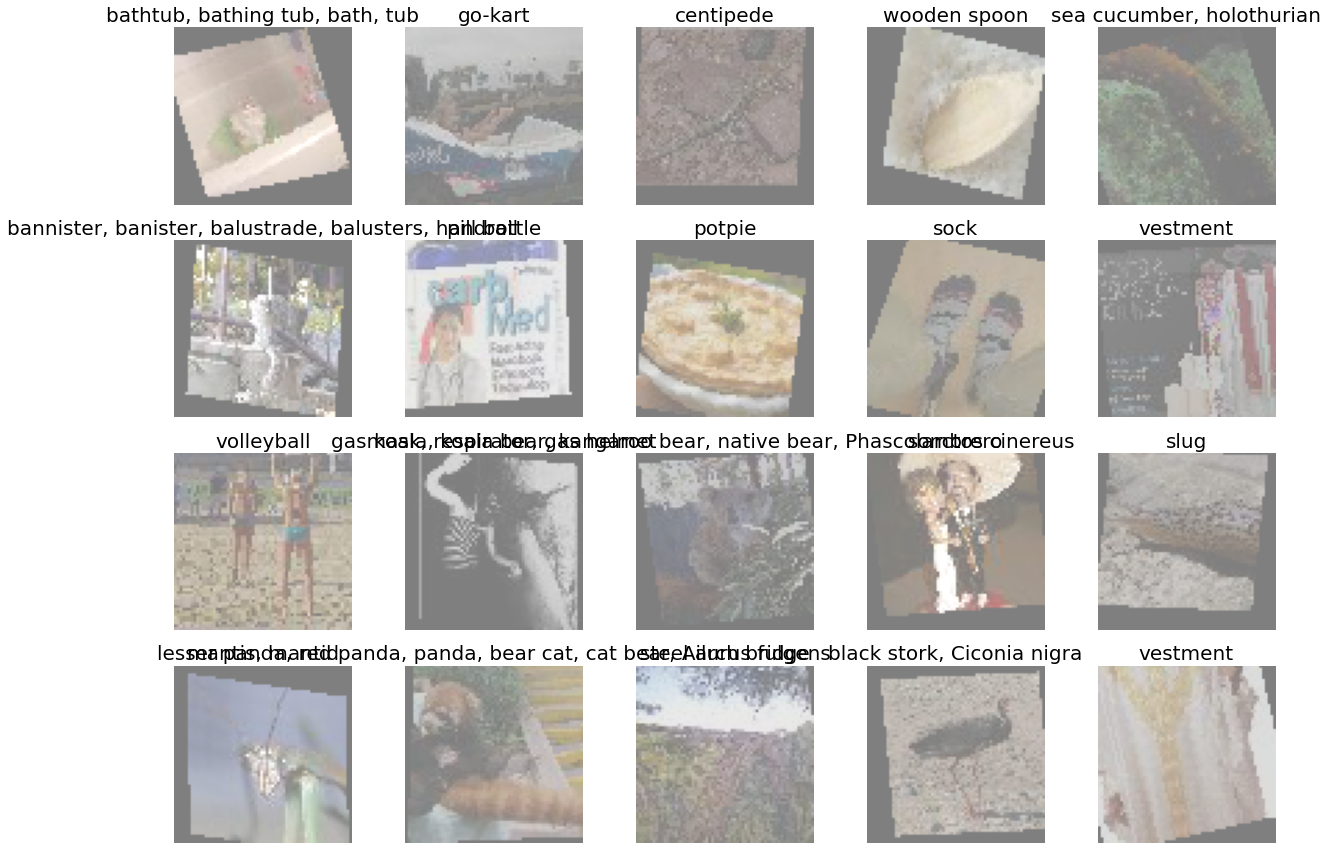

In [26]:
# 正解ラベル定義
classes = train_dataset.classes

# 検証データ最初の50個の表示
show_images_labels(test_loader2, classes, None, None)

# Def Model

### Parameters

In [27]:
# output degree: 出力次元数
# number of classes: 分類先クラス数
n_output = len(classes)

# number of nodes of hidden layer 隠れ層のノード数
n_hidden = 256 

print(f'n_hidden: {n_hidden} n_output: {n_output}')



n_hidden: 256 n_output: 200


In [28]:
class CNN(nn.Module):
    def __init__(self, n_output, n_hidden):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d((2,2))
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p=0.3)
        self.l1 = nn.Linear(2048, n_hidden) # 16*32*32
        self.l2 = nn.Linear(n_hidden, n_output)

        
        self.features = nn.Sequential(
            
            self.conv1,
            self.relu,
            self.maxpool,
            
            self.conv2,
            self.relu,
            self.maxpool,          
            
            self.conv3,
            self.relu,
            self.maxpool,  
            
#             self.flatten,
#             self.l1,
#             self.relu,
#             self.l2,
            
#             nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2), # output: 16, 32, 32

#             nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2), # output: 16, 16, 16 

#             nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2), # output: 32, 8, 8 


#             nn.Flatten(), # 16 x 2048
#             nn.Linear(2048, n_hidden),
#             nn.ReLU(),
#             nn.Linear(n_hidden, n_output),
#             self.conv1,# out: 16, 64, 64
#             self.relu,# out: 16, 64, 64
#             self.conv2,# out: 16, 64, 64
#             self.relu,# out: 16, 64, 64
#             self.maxpool # out: 16, 32, 32
        )

        self.classifier = nn.Sequential(
           self.l1,
           self.relu,
           self.l2)

    def forward(self, x):
        x1 = self.features(x)
        x2 = self.flatten(x1)
        x3 = self.classifier(x2)
        return x3

### Create model instance

In [29]:
# create model instanceモデルインスタンス生成
net = CNN(n_output, n_hidden).to(device)

# loss function: cross entropy 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# learning ratio: 学習率
lr = 0.01

# optimizer: gradient 最適化関数: 勾配降下法
optimizer = torch.optim.SGD(net.parameters(), lr=lr)



In [30]:
# summary of model: モデルの概要表示

print(net)


CNN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten()
  (dropout): Dropout(p=0.3, inplace=False)
  (l1): Linear(in_features=2048, out_features=256, bias=True)
  (l2): Linear(in_features=256, out_features=200, bias=True)
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel

In [31]:
# summary of model:モデルのサマリー表示

summary(net,(100,3,64,64),depth=1)

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      --                        --
├─Sequential: 1-1                        [100, 32, 8, 8]           8,176
├─Conv2d: 1-2                            [100, 16, 64, 64]         1,216
├─ReLU: 1-3                              [100, 16, 64, 64]         --
├─MaxPool2d: 1-4                         [100, 16, 32, 32]         --
├─Conv2d: 1-5                            [100, 16, 32, 32]         2,320
├─ReLU: 1-6                              [100, 16, 32, 32]         --
├─MaxPool2d: 1-7                         [100, 16, 16, 16]         --
├─Conv2d: 1-8                            [100, 32, 16, 16]         4,640
├─ReLU: 1-9                              [100, 32, 16, 16]         --
├─MaxPool2d: 1-10                        [100, 32, 8, 8]           --
├─Flatten: 1-11                          [100, 2048]               --
├─Sequential: 1-12                       [100, 200]                575,94

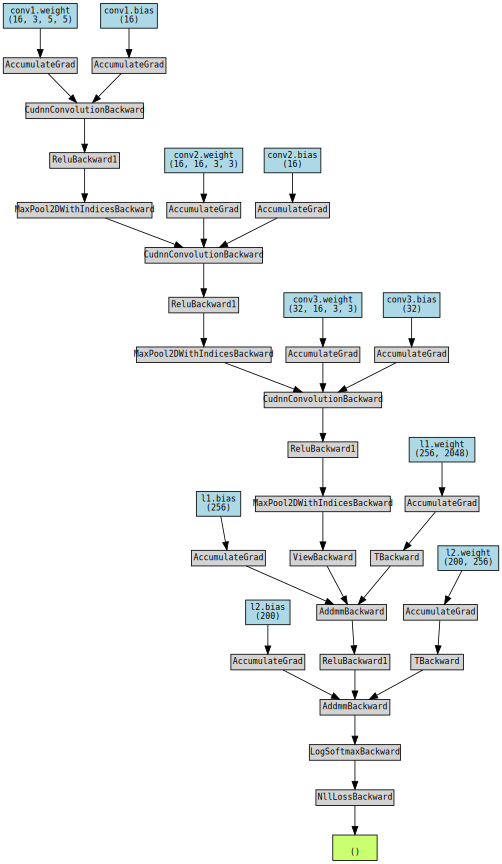

In [32]:
# calc loss: 損失計算
loss = eval_loss(test_loader2, device, net, criterion)

# visualize calc loss: 損失の計算グラフ可視化
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)



In [34]:
# init randam, 乱数初期化
torch_seed()

# create model instanceモデルインスタンス生成
net = CNN(n_output, n_hidden).to(device)

# loss function: cross entropy損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# learning step 学習率
lr = 0.01

# optimizser 最適化関数: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# epock 繰り返し回数
num_epochs = 70

# output 評価結果記録用
history2 = np.zeros((0,5))

# learning: 学習
history2 = fit(net, optimizer, criterion, num_epochs, train_loader2, test_loader2, device, history2)



  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [1/70], loss: 0.05299 acc: 0.00504 val_loss: 0.05299, val_acc: 0.00550


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [2/70], loss: 0.05298 acc: 0.00519 val_loss: 0.05298, val_acc: 0.00590


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [3/70], loss: 0.05297 acc: 0.00541 val_loss: 0.05297, val_acc: 0.00660


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [4/70], loss: 0.05294 acc: 0.00798 val_loss: 0.05292, val_acc: 0.00930


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [5/70], loss: 0.05280 acc: 0.01059 val_loss: 0.05251, val_acc: 0.01460


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [6/70], loss: 0.05135 acc: 0.01896 val_loss: 0.05055, val_acc: 0.02570


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [7/70], loss: 0.05021 acc: 0.02791 val_loss: 0.04994, val_acc: 0.03250


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [8/70], loss: 0.04959 acc: 0.03509 val_loss: 0.04943, val_acc: 0.03860


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [9/70], loss: 0.04912 acc: 0.04161 val_loss: 0.04907, val_acc: 0.04240


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [10/70], loss: 0.04874 acc: 0.04588 val_loss: 0.04863, val_acc: 0.04910


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [11/70], loss: 0.04833 acc: 0.05076 val_loss: 0.04836, val_acc: 0.05030


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [12/70], loss: 0.04786 acc: 0.05492 val_loss: 0.04805, val_acc: 0.04970


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [13/70], loss: 0.04738 acc: 0.05930 val_loss: 0.04730, val_acc: 0.05860


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [14/70], loss: 0.04676 acc: 0.06602 val_loss: 0.04661, val_acc: 0.06760


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [15/70], loss: 0.04602 acc: 0.07522 val_loss: 0.04588, val_acc: 0.07560


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [16/70], loss: 0.04516 acc: 0.08576 val_loss: 0.04524, val_acc: 0.08100


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [17/70], loss: 0.04443 acc: 0.09549 val_loss: 0.04452, val_acc: 0.08980


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [18/70], loss: 0.04372 acc: 0.10647 val_loss: 0.04406, val_acc: 0.10020


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [19/70], loss: 0.04319 acc: 0.11159 val_loss: 0.04360, val_acc: 0.10870


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [20/70], loss: 0.04270 acc: 0.11887 val_loss: 0.04333, val_acc: 0.11480


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [21/70], loss: 0.04223 acc: 0.12586 val_loss: 0.04322, val_acc: 0.11220


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [22/70], loss: 0.04173 acc: 0.13198 val_loss: 0.04207, val_acc: 0.12740


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [23/70], loss: 0.04133 acc: 0.13748 val_loss: 0.04201, val_acc: 0.12770


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [24/70], loss: 0.04087 acc: 0.14417 val_loss: 0.04179, val_acc: 0.13030


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [25/70], loss: 0.04047 acc: 0.15017 val_loss: 0.04099, val_acc: 0.14150


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [26/70], loss: 0.04009 acc: 0.15519 val_loss: 0.04084, val_acc: 0.14250


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [27/70], loss: 0.03969 acc: 0.15984 val_loss: 0.04081, val_acc: 0.14710


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [28/70], loss: 0.03933 acc: 0.16539 val_loss: 0.04013, val_acc: 0.15480


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [29/70], loss: 0.03901 acc: 0.16903 val_loss: 0.04028, val_acc: 0.15150


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [30/70], loss: 0.03866 acc: 0.17576 val_loss: 0.03966, val_acc: 0.16250


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [31/70], loss: 0.03836 acc: 0.17788 val_loss: 0.03992, val_acc: 0.15760


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [32/70], loss: 0.03804 acc: 0.18370 val_loss: 0.03916, val_acc: 0.17000


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [33/70], loss: 0.03783 acc: 0.18702 val_loss: 0.03938, val_acc: 0.16620


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [34/70], loss: 0.03751 acc: 0.19089 val_loss: 0.03927, val_acc: 0.16710


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [35/70], loss: 0.03732 acc: 0.19350 val_loss: 0.03950, val_acc: 0.16240


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [36/70], loss: 0.03704 acc: 0.19723 val_loss: 0.03868, val_acc: 0.17230


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [37/70], loss: 0.03682 acc: 0.20149 val_loss: 0.03876, val_acc: 0.17710


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [38/70], loss: 0.03658 acc: 0.20400 val_loss: 0.03831, val_acc: 0.18030


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [39/70], loss: 0.03638 acc: 0.20892 val_loss: 0.03820, val_acc: 0.18230


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [40/70], loss: 0.03618 acc: 0.21051 val_loss: 0.03896, val_acc: 0.17810


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [41/70], loss: 0.03595 acc: 0.21421 val_loss: 0.03810, val_acc: 0.18480


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [42/70], loss: 0.03575 acc: 0.21717 val_loss: 0.03760, val_acc: 0.19260


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [43/70], loss: 0.03553 acc: 0.22119 val_loss: 0.03757, val_acc: 0.19440


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [44/70], loss: 0.03538 acc: 0.22351 val_loss: 0.03772, val_acc: 0.19150


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [45/70], loss: 0.03511 acc: 0.22679 val_loss: 0.03726, val_acc: 0.20370


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [46/70], loss: 0.03495 acc: 0.22926 val_loss: 0.03710, val_acc: 0.20300


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [47/70], loss: 0.03476 acc: 0.23321 val_loss: 0.03709, val_acc: 0.20430


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [48/70], loss: 0.03460 acc: 0.23614 val_loss: 0.03743, val_acc: 0.19460


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [49/70], loss: 0.03441 acc: 0.23897 val_loss: 0.03659, val_acc: 0.21140


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [50/70], loss: 0.03426 acc: 0.24320 val_loss: 0.03692, val_acc: 0.20580


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [51/70], loss: 0.03415 acc: 0.24421 val_loss: 0.03710, val_acc: 0.20900


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [52/70], loss: 0.03398 acc: 0.24613 val_loss: 0.03645, val_acc: 0.21250


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [53/70], loss: 0.03379 acc: 0.24864 val_loss: 0.03656, val_acc: 0.21500


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [54/70], loss: 0.03370 acc: 0.25049 val_loss: 0.03641, val_acc: 0.21810


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [55/70], loss: 0.03351 acc: 0.25341 val_loss: 0.03644, val_acc: 0.21690


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [56/70], loss: 0.03334 acc: 0.25682 val_loss: 0.03616, val_acc: 0.22200


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [57/70], loss: 0.03321 acc: 0.25847 val_loss: 0.03629, val_acc: 0.22150


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [58/70], loss: 0.03310 acc: 0.26138 val_loss: 0.03635, val_acc: 0.21620


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [59/70], loss: 0.03299 acc: 0.26143 val_loss: 0.03618, val_acc: 0.22110


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [60/70], loss: 0.03284 acc: 0.26506 val_loss: 0.03625, val_acc: 0.21970


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [61/70], loss: 0.03275 acc: 0.26724 val_loss: 0.03684, val_acc: 0.21590


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [62/70], loss: 0.03260 acc: 0.26980 val_loss: 0.03607, val_acc: 0.22230


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [63/70], loss: 0.03249 acc: 0.26856 val_loss: 0.03585, val_acc: 0.22560


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [64/70], loss: 0.03232 acc: 0.27382 val_loss: 0.03573, val_acc: 0.23380


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [65/70], loss: 0.03226 acc: 0.27688 val_loss: 0.03546, val_acc: 0.23430


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [66/70], loss: 0.03211 acc: 0.27621 val_loss: 0.03563, val_acc: 0.23310


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [67/70], loss: 0.03202 acc: 0.27961 val_loss: 0.03599, val_acc: 0.22560


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [68/70], loss: 0.03191 acc: 0.28147 val_loss: 0.03534, val_acc: 0.23730


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [69/70], loss: 0.03181 acc: 0.28110 val_loss: 0.03561, val_acc: 0.23430


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [70/70], loss: 0.03166 acc: 0.28356 val_loss: 0.03580, val_acc: 0.22930


Initial: loss: 0.05299 accuracy: 0.00550
Final: loss: 0.03580 accuracy: 0.22930


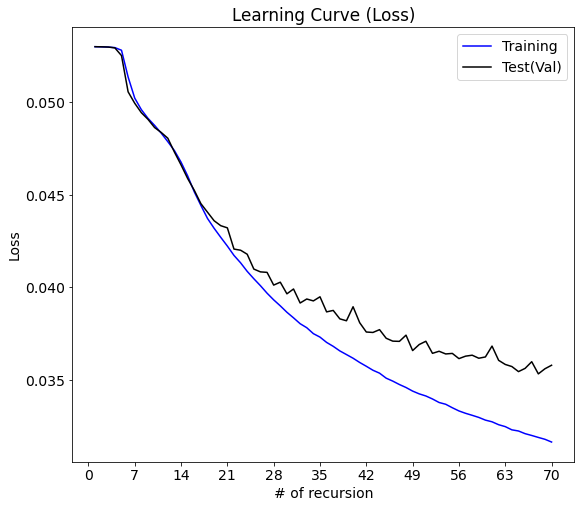

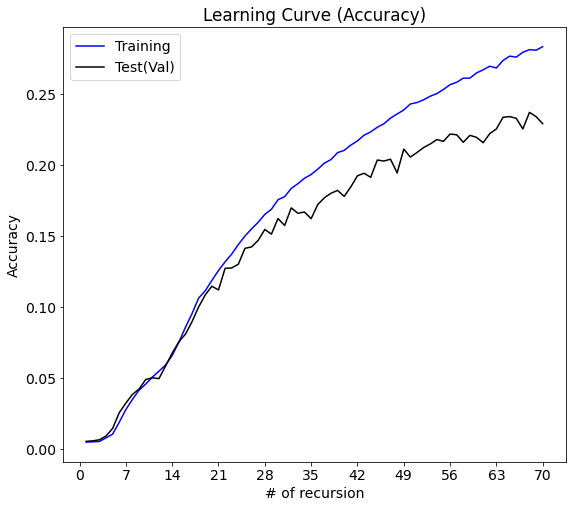

In [35]:
# 評価

evaluate_history(history2)


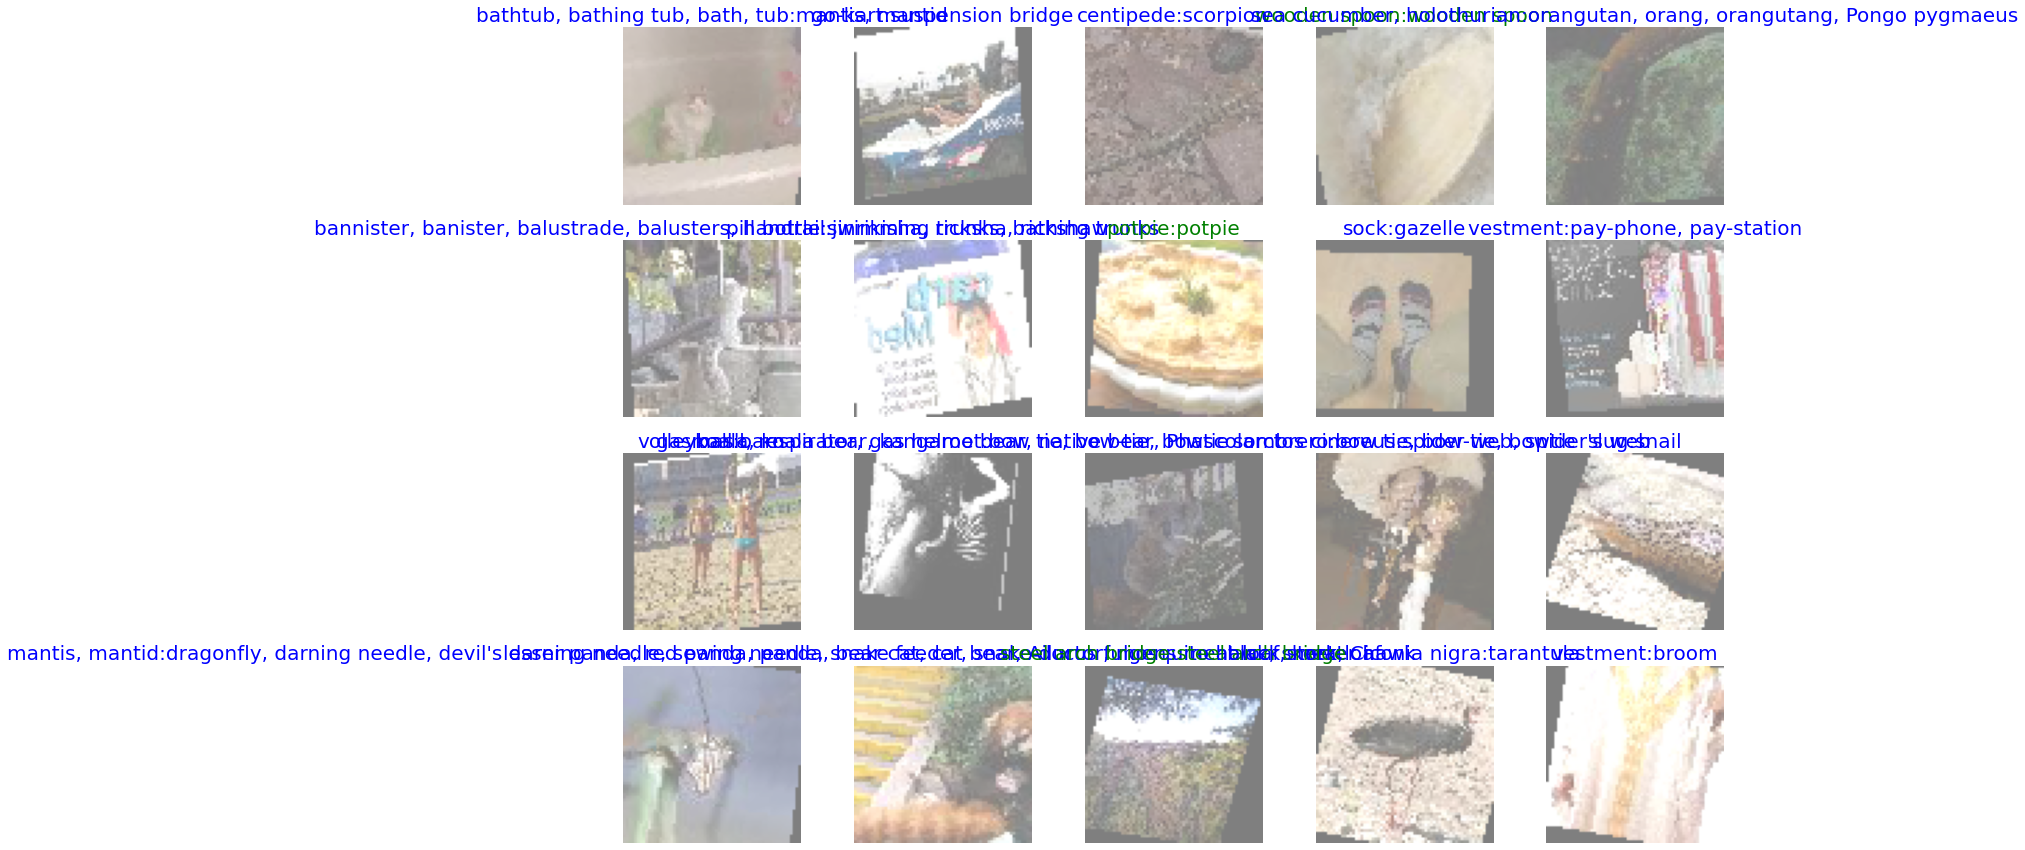

In [36]:
# 最初の50個の表示

show_images_labels(test_loader2, classes, net, device)

